In [8]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
path = r"C:\Users\lluis\OneDrive\Documentos\ETH\H4G\git\wwf\data\forest_geodata\find.json"
from shapely.geometry import shape
import json 
f = open(path)
data = json.load(f)
data = data['results']

In [9]:
data[100]['attributes']['objnummer']

'160_AG_W178'

In [10]:
multipoly = MultiPolygon([Polygon(poly) for poly in data[0]['geometry']['rings']])

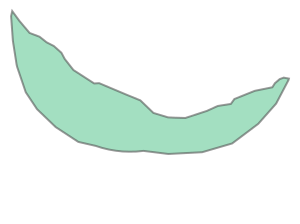

In [11]:
multipoly

In [12]:
#gdf = gpd.GeoDataFrame({'id': 0, 'geometry': MultiPolygon([Polygon(poly) for poly in data[0]['geometry']['rings']])})
#for i in range(len(data)-1):
#    gdf.append({'id': i+1, 'geometry': MultiPolygon([Polygon(poly) for poly in data[i+1]['geometry']['rings']])}, ignore_index=True)
gdf = gpd.GeoDataFrame()

In [13]:
gdf["geometry"] = [MultiPolygon([Polygon(poly) for poly in data[k]['geometry']['rings']]) for k in range(len(data))]
gdf["objnummer"] = [data[k]['attributes']['objnummer'] for k in range(len(data))]

In [14]:
gdf

geometry     objnummer
0    MULTIPOLYGON (((667009.000 246820.100, 667037....  160_AG_W1000
1    MULTIPOLYGON (((666948.600 247116.900, 666927....  160_AG_W1000
2    MULTIPOLYGON (((666985.900 248409.200, 666996....  160_AG_W1006
3    MULTIPOLYGON (((642939.600 254778.200, 642928....   160_AG_W101
4    MULTIPOLYGON (((652041.700 253347.600, 652040....  160_AG_W1011
..                                                 ...           ...
196  MULTIPOLYGON (((657516.300 256029.200, 657527....   160_AG_W481
197  MULTIPOLYGON (((658959.200 271528.300, 658975....   160_AG_W488
198  MULTIPOLYGON (((673318.300 266840.600, 673334....   160_AG_W497
199  MULTIPOLYGON (((649371.600 258540.600, 649381....    160_AG_W50
200  MULTIPOLYGON (((646922.100 266741.100, 646934....   160_AG_W500

[201 rows x 2 columns]

In [15]:
gdf = gdf.set_crs('EPSG:21781')

In [16]:
gdf = gdf.to_crs('epsg:4326', epsg = 'epsg:21781') #Going from Swiss to Longitude Latitude coords

In [17]:
gdf.shape[0]

201

In [18]:
gdf.centroid

C:\Users\lluis\AppData\Local\Temp\ipykernel_24936\2017122361.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid


0      POINT (8.32673 47.36835)
1      POINT (8.32611 47.37299)
2      POINT (8.32655 47.38248)
3      POINT (8.00910 47.44319)
4      POINT (8.12111 47.42844)
                 ...           
196    POINT (8.20093 47.45176)
197    POINT (8.21874 47.59271)
198    POINT (8.41252 47.54743)
199    POINT (8.09310 47.47596)
200    POINT (8.06061 47.54885)
Length: 201, dtype: geometry

In [19]:
gdf2 = gdf

In [20]:
from numpy import infty
def boundaryreduction(boundary):
    newcoords = []
    i=0
    while i<len(boundary.coords[0:]):
        newcoords.append(boundary.coords[i])
        i+=int(len(boundary.coords[0:])/10)
    newboundary = LineString(newcoords)
    return newboundary

In [21]:
def distance(point, boundaries, reducedimensionality=False):
    min = infty
    for boundary in boundaries:
        if reducedimensionality==True:
            boundary = boundaryreduction(boundary)
        dist = boundary.distance(point)
        if min > dist:
            min = dist
        
    return min

In [36]:
data[0]['attributes']

{'gisteilobjekt': 2.49781773045644,
 'gisflaeche': 4.9764692715043,
 'gesflaeche': 5.0,
 'objnummer': '160_AG_W1000',
 'name': 'Foort',
 'mcpfe_class_de': 'MCPFE1.2 Minimale Eingriffe',
 'mcpfe_class_fr': 'MCPFE1.2 Interventions minimales',
 'mcpfe_class_it': 'MCPFE1.2 Interventi minimi',
 'mcpfe_class_en': 'MCPFE1.2 Minimum Intervention',
 'label': 'Foort'}

In [22]:

def Nclosestforests(point, gdf2, N=1, reducedimensionality = False):
    i = 0
    ordereddistances = [infty]*(N+1)
    distancesinkm = [infty]*(N+1)
    attributes = [None]*(N+1)
    keys = [0]*(N+1)
    while i < gdf2.shape[0]:
        dista = distance(point, gdf2.iloc[i]["geometry"].boundary, reducedimensionality = reducedimensionality)
        distainkm = distanceinkm(point, gdf2.iloc[i]["geometry"].centroid)
        attribute = data[i]['attributes']
        j = 0
        while j < N:
            if ordereddistances[N-j-1]>dista:
                ordereddistances[N-j] = ordereddistances[N-j-1]
                ordereddistances[N-j-1] = dista
                distancesinkm[N-j] = distancesinkm[N-j-1]
                distancesinkm[N-j-1] = distainkm
                attributes[N-j] = attributes[N-j-1]
                attributes[N-j-1] = attribute
                keys[N-j] = keys[N-j-1]
                keys[N-j-1] = i
                j+=1
            else: break
        i+=1
    return keys[:-1], distancesinkm[:-1], attributes[:-1]


NameError: name 'keys' is not defined

In [23]:
print(gdf2.iloc[1]['geometry'].centroid)

POINT (8.326108714912671 47.37298629295566)


In [26]:
Nclosestforests(gdf2.iloc[0]['geometry'].centroid, gdf2 = gdf2, N = 3)

C:\Users\lluis\AppData\Local\Temp\ipykernel_24936\2953325366.py:3: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for boundary in boundaries:


([0, 1, 2],
 [0.0, 0.5142758353481165, 1.5545380833791183],
 ['160_AG_W1000', '160_AG_W1000', '160_AG_W1006'])

In [27]:
print(gdf2.iloc[0]['geometry'].centroid)

POINT (8.326726234279151 47.36835387989349)


In [28]:
print(gdf2.iloc[1]['geometry'].centroid)

POINT (8.326108714912671 47.37298629295566)


In [29]:
pointT0 = Point(gdf2.iloc[0]['geometry'].centroid.coords[0][1],gdf2.iloc[0]['geometry'].centroid.coords[0][0])
pointT1 = Point(gdf2.iloc[1]['geometry'].centroid.coords[0][1],gdf2.iloc[1]['geometry'].centroid.coords[0][0])

In [30]:
point1 = gdf2.iloc[0]['geometry'].centroid
print(point1.distance(gdf2.iloc[1]['geometry'].centroid))

0.00467339073334633


In [31]:
import math
def distanceinkm(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    origin = origin.coords[0]
    destination = destination.coords[0]
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

0.5171957537958899
